<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# 線性迴歸

## 簡單線性迴歸

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

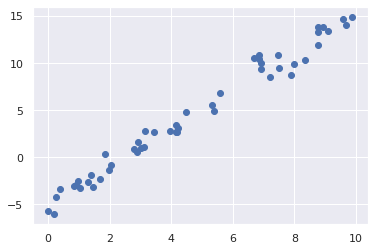

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

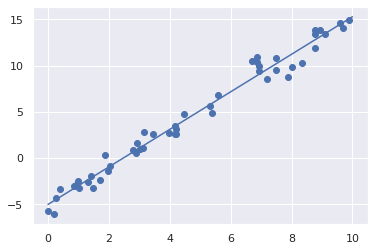

In [3]:
# 使用LinearRegression訓練資料，並建立一條最佳擬合的線條
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [4]:
# 算出斜率和截距
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


除了簡單的直線擬合之外，它還可以擬合一個超平面到更高維度的資料點。

$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$

上面的算式有很多x值。在幾何學上，這類似於去擬合一個平面到三度空間的點，或是擬合一個超平面到更高維度的資料點。

此種在高維度上的迴歸，本質就讓它們非常難以視覺化，但可以透過建立一些範例資料來檢視它是怎麼運作的。

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]


在此，資料$y$是從3個隨機的$x$值所建立的，而線性迴歸回復了被使用於建立資料的係數。

此種方式，可以使用單一的``LinearRegression``去擬合線條、平面、或是超平面到資料中。

### 多項式函數


In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False) # 多項式函數:PolynomialFeatures(degree=2, include_bias=True)
poly.fit_transform(x[:, None]) # Fit to data, then transform it.

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

以上可以看出此轉換器計算出每一個值的指數，把一維陣列轉換成三維陣列。而新建立的較高維度資料表示方式，就可以接著被放到一個線性迴歸中。

In [8]:
from sklearn.pipeline import make_pipeline # Construct a Pipeline from the given estimators.
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression()) 

在位置中進行轉換後，可以使用線性模型去擬合更複雜的$x$和$y$關係。 

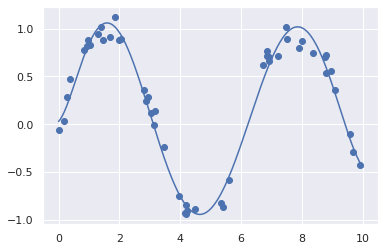

In [9]:
# 有雜訊的sin函數
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

線性模型經由第7階多項式函數的使用，可提供非線性資料好的訓練結果。

## 正規化(Regularization)

藉由處罰模型參數中那些過大的值來限制在模型中明顯的突破就會比較好一些，避免函數過度擬合。

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=1.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

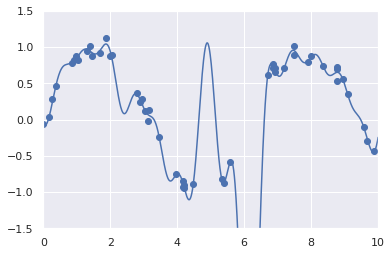

In [15]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

這些資料被投影到30維的基礎，此模型就太過於彈性，使得它極度的被受限在資料點之間的位置。如果把此高斯係數以及和它相對應的位置畫出來，就可以看出原因了。

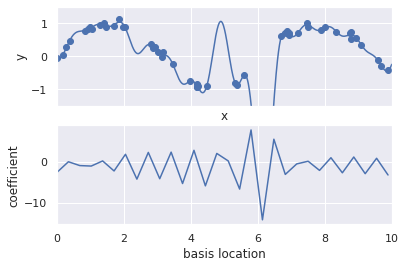

In [16]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### Ridge regression ($L_2$ Regularization)

此種方式處罰模型係數的平方和(2-範例，2-norms); 在此例，在模型擬合時的處罰(penalty)如下: 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
其中$\alpha$是一個自由的參數，它用來控制處罰的強度。此類型的處罰模型被建立在 Scikit-Learn中的``Ridge``評估器中。

不相干的變數迴歸係數會被逼近為0(不會剛好等於0)，我們可以藉此降低資料集中的雜訊，幫助我們更清楚的識別出模型中真正的訊號(signals)。

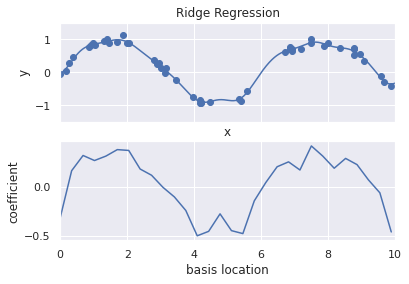

In [21]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1)) # Constant that multiplies the L2 term, controlling regularization strength
basis_plot(model, title='Ridge Regression')

### Lasso regression ($L_1$ regularization)

以迴歸係數絕對值的和(1-範數，1-norms)來作為處罰:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
雖然在概念上這和ridge regression相似，但結果卻不一樣:例如，因為幾何學上的理由，lasso regression傾向較利於*分散模型*；也就是說，它會優先的把模型係數設定到剛好為0。


與Ridge模型最大的差別，就是Lasso會將不具影響力的變數迴歸係數變成0，等於可以自動化的進行變數篩選(Feature selection)。

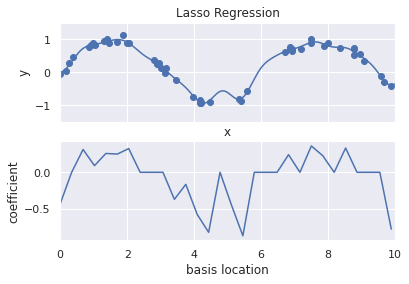

In [22]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

在Lasso regression處罰中，大部分的係數都正好為0，此時函數的行為就會被可用的基函數的小型子集合所塑模。如同ridge regression一樣可以使用alpha參數來微調處罰的強度，而且應該藉由交叉驗證加以決定。

###比較

當使用者的模型中具有過多的參數，想自動化把不重要的變數給移除，那應該要選擇Lasso model。

如果我們想找到模型當中重要的參數可以透過Ridge model來去辨別哪些參數是重要的，因為不重要的參數會在模式當中迴歸係數會趨近於0，但因為不會真的消失，所以可以根據迴歸係數的大小來得到重要參數的排名。